In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Epoch [10/100], Loss: 0.0844
Epoch [20/100], Loss: 0.0405
Epoch [30/100], Loss: 0.0317
Epoch [40/100], Loss: 0.0295
Epoch [50/100], Loss: 0.0271
Epoch [60/100], Loss: 0.0261
Epoch [70/100], Loss: 0.0254
Epoch [80/100], Loss: 0.0244
Epoch [90/100], Loss: 0.0221
Epoch [100/100], Loss: 0.0266
Train MSE: 303.07933381267065, Test MSE: 379.14718702423045


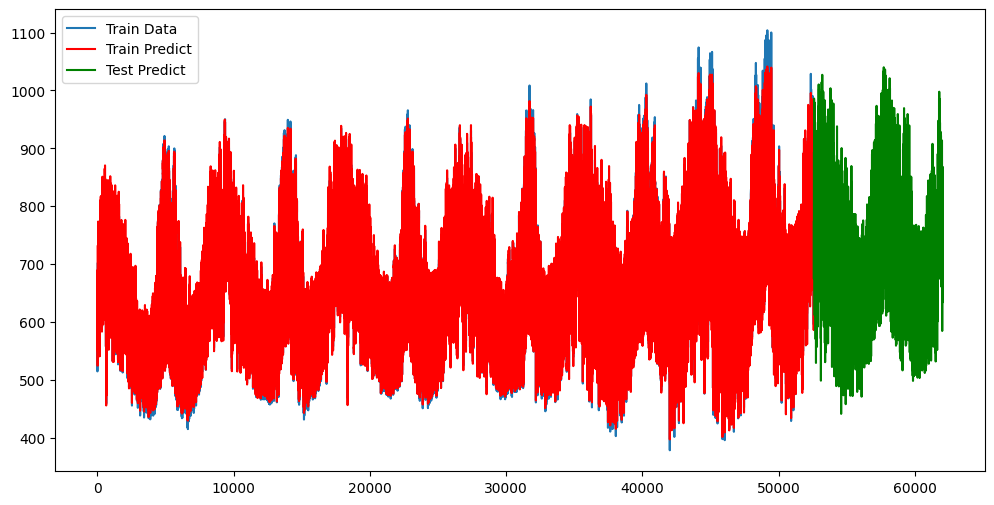

RNN forecast results saved to rnn_forecast_results.csv


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
file_path = './data/data.csv'  # 데이터 파일 경로
data = pd.read_csv(file_path)  # CSV 파일 로드

# 학습 및 테스트 데이터 분리
train_years = [17, 18, 19, 20, 21, 22]  # 학습에 사용할 연도
test_year = 23  # 테스트에 사용할 연도

train_data = data[data['year'].isin(train_years)]  # 학습 데이터
test_data = data[data['year'] == test_year]  # 테스트 데이터

# 수요량만 추출
train_series = train_data['수요량'].values.reshape(-1, 1)
test_series = test_data['수요량'].values.reshape(-1, 1)

# 데이터 스케일링
scaler = StandardScaler()
train_series_scaled = scaler.fit_transform(train_series)
test_series_scaled = scaler.transform(test_series)

# 시계열 데이터를 RNN 입력 형식으로 변환
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 24  # 시퀀스 길이 설정 (24시간)
X_train, y_train = create_sequences(train_series_scaled, seq_length)
X_test, y_test = create_sequences(test_series_scaled, seq_length)

# 데이터 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 모델 하이퍼파라미터 설정
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.01

# 모델, 손실 함수 및 최적화 기법 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    train_predict = model(X_train.to(device))
    test_predict = model(X_test.to(device))
    train_predict = scaler.inverse_transform(train_predict.cpu().numpy())
    test_predict = scaler.inverse_transform(test_predict.cpu().numpy())

# 성능 평가
train_mse = mean_squared_error(train_series[seq_length:], train_predict)
test_mse = mean_squared_error(test_series[seq_length:], test_predict)
print(f'Train MSE: {train_mse}, Test MSE: {test_mse}')

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Train Data')
plt.plot(range(seq_length, seq_length + len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_series), len(train_series) + len(test_predict)), test_predict, label='Test Predict', color='green')
plt.legend()
plt.show()

# 예측 결과 저장
results = test_data[seq_length:].copy()
results['Forecast'] = test_predict
results.to_csv('rnn_forecast_results.csv', index=False)
print('RNN forecast results saved to rnn_forecast_results.csv')
